In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# Model Building

At this point data consists of no apparent outlier and missing values. Qualitative features have been encoded appropriately. All features are in numerical format. Dataset is ready to train machine learning models.

In this notebook I train multiple machine learning models, fine-tune them and evaluate their performance using cross-validation. Root-Mean-Squared-Error (RMSE) between the logarithm of predicted and observed sale price is used as the evaluation metric for each validation set. Using logarithm of the sale price as the target variables ensures that the errors in predicting expensive and cheap houses will affect the results equally.

**Table of Contents** 
1. [Data Splitting](#Data-Splitting)
2. [Feature Standardization](#Feature-Standardization)
3. [Models](#Models)  
    3.1. [Linear Regression](#Linear-Regression)  
    3.2. [Ridge Regression](#Ridge-Regression)  
    3.3. [Lasso Regression](#Lasso-Regression)  
    3.4. [Elastic Net Regression](#Elastic-Net-Regression)  
    3.5. [Support Vector Machine Regression](#Support-Vector-Machine-Regression)  
    3.6. [Random Forest](#Random-Forest)    
    3.7. [Adaptive Boost](#Adaptive-Boost)    
    3.8. [Gradient Boost](#Gradient-Boost)    
4. [Model Performance](#Model-Performance)

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Import collection library
from collections import defaultdict

# Import visualization libraries
import matplotlib as mpl
import seaborn as sns
sns.set(style ='white',font_scale=1.25)
%matplotlib inline

# Set waring to 'ignore' to prevent them from prining on screen
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''Import the processed dataset'''
with open('data/processed_data.pkl','rb') as file:
    train,y,test,FEATURES = pickle.load(file)
    
for feat in ['ExterQual','KitchenQual']:
    train[feat] = train[feat].astype(np.float)
    test[feat] = test[feat].astype(np.float)

## Data Splitting

Data is split in 70% training and 30% test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1017, 466)
X_test : (437, 466)
y_train : (1017,)
y_test : (437,)


## Feature Standardization

Standardize all features except those that are one hot encoded.

In [5]:
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat', 'interactions', 'interactions_num'])

In [6]:
feat_to_norm = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num'] + FEATURES['interactions_num']
print('Total %i features to normalize' %(len(feat_to_norm)))

Total 246 features to normalize


In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

print("X_train_preproc : " + str(X_train_preproc.shape))
print("X_test_preproc : " + str(X_test_preproc.shape))

X_train_preproc : (1017, 466)
X_test_preproc : (437, 466)


In [8]:
'''Initialize a named tuple that will store cross-validation mean and std of the model performance metric (RSME)'''

from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_train_rmse','cv5_std_train_rmse',
                              'cv5_mean_test_rmse','cv5_std_test_rmse'])
model_list = []

## Models

### Linear Regression

In [9]:
# Import linear regression model
from sklearn.linear_model import LinearRegression

# Import mean_squared_error and r2_score libraries
from sklearn.metrics import mean_squared_error, r2_score

# import cross validation score library
from sklearn.model_selection import cross_val_score

In [10]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.9648529652760376
Test R-sq: 0.4414456763442427


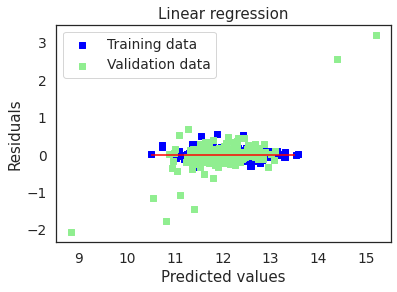

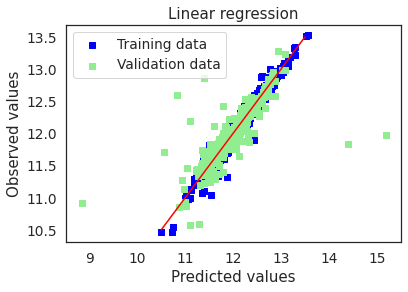

In [12]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [13]:
cv5_train_rmse =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.20598253 0.20961447 0.70670994 7.79822149 0.26921657]
---------------------------------------------------------------------------
cv5 test rmse: [0.76827203 1.138192   0.81778919 1.28980219 0.75990774]


### 3.2. Ridge Regression

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [15]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.909347559888787
MSE: 0.013652840497577244
RMSE: 0.11684537003055467
--------------------------------------------------
R-sq orig price: 0.9101261340596172
MSE orig price: 478516927.3691223
RMSE orig price: 21875.029768416825


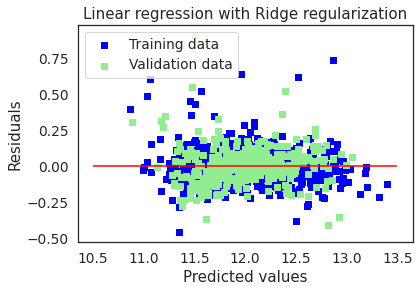

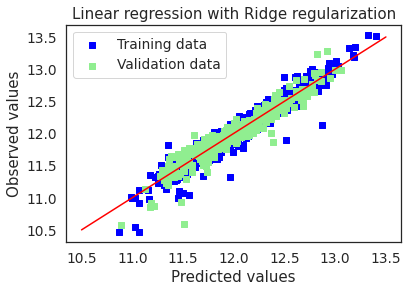

Ridge picked 454 features and eliminated the other 12 features


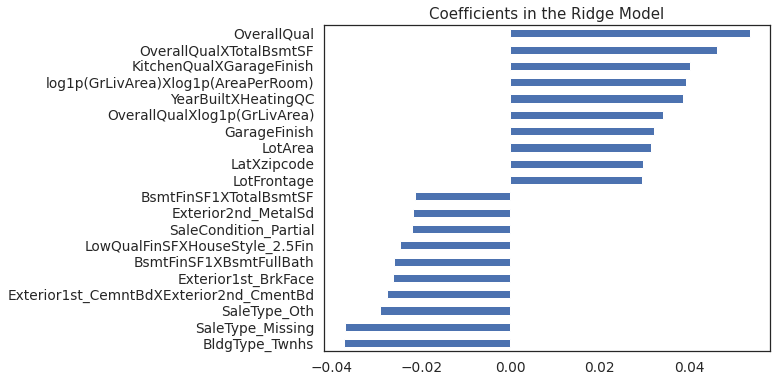

In [16]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [17]:
cv5_train_rmse =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13729775 0.15145262 0.11535025 0.12181316 0.10309681]
---------------------------------------------------------------------------
cv5 test rmse: [0.12090563 0.12652353 0.14737171 0.10683139 0.10270972]


### 3.3. Lasso Regression

In [18]:
from sklearn.linear_model import LassoCV, Lasso

In [19]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0003


In [20]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.900911643068392
MSE: 0.014923343824993315
RMSE: 0.12216113876758564
--------------------------------------------------
R-sq orig price: 0.8969800704761717
MSE orig price: 548510733.5454615
RMSE orig price: 23420.30600879206


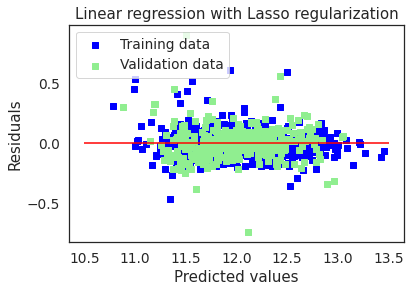

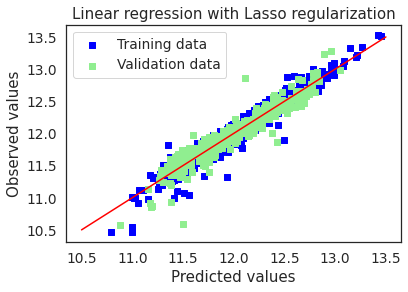

Lasso picked 178 features and eliminated the other 291 features


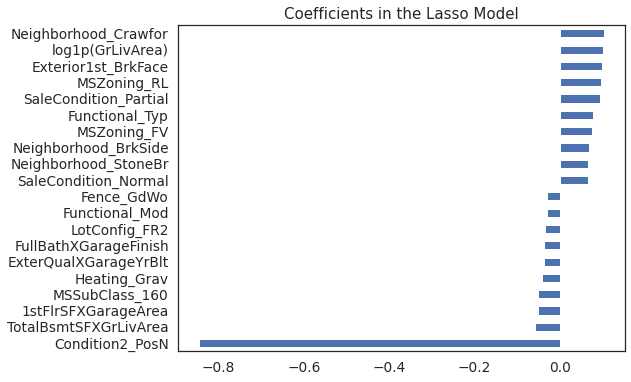

In [19]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [21]:
cv5_train_rmse =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13966214 0.14872952 0.11481515 0.11832687 0.1029308 ]
---------------------------------------------------------------------------
cv5 test rmse: [0.12335639 0.13357488 0.15226293 0.10698545 0.10213062]


### 3.4. Elastic Net Regression

In [22]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [23]:
enet = ElasticNetCV(l1_ratio=np.arange(0,1.1,0.1),
             alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
             cv=5,
             max_iter=50000,
             n_jobs=16,
             random_state=42)
enet.fit(X_train_preproc, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1],
             cv=5,
             l1_ratio=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=50000, n_jobs=16, random_state=42)

In [24]:
print('Best alpha: ',enet.alpha_)
print('Best l1_ratio: ',enet.l1_ratio_)

Best alpha:  0.0006
Best l1_ratio:  0.9


In [25]:
enet = ElasticNet(l1_ratio=0.9,alpha=0.0006)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9089864660642593
MSE: 0.013707223549868945
RMSE: 0.11707785251647275
--------------------------------------------------
R-sq: 0.9087354556227382
MSE: 485921339.8266356
RMSE: 22043.623563893383


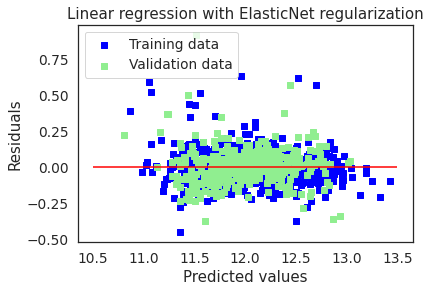

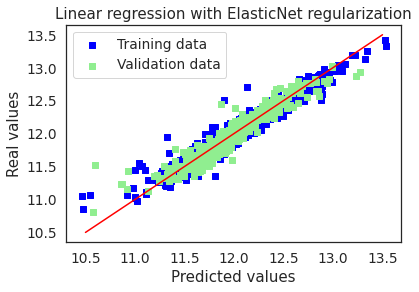

ElasticNet picked 146 features and eliminated the other 320 features


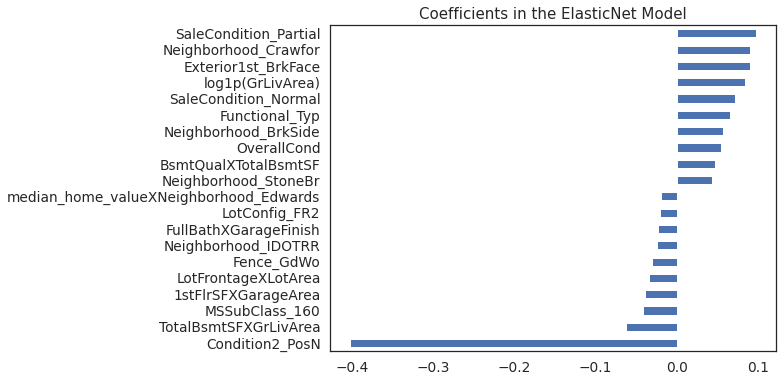

In [26]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [27]:
cv5_train_rmse =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='enet',params=enet.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13852348 0.15183482 0.11231201 0.12001222 0.10056093]
---------------------------------------------------------------------------
cv5 test rmse: [0.12009171 0.12695604 0.14997704 0.10703355 0.09994046]


### 3.5. Support Vector Machine Regression

In [28]:
from sklearn.svm import SVR

In [30]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='scale', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8955105394422324
MSE: 0.015736784767436555
RMSE: 0.12544634218436404
--------------------------------------------------
R-sq: 0.9072454176935487
MSE: 493854773.69062626
RMSE: 22222.843510465224


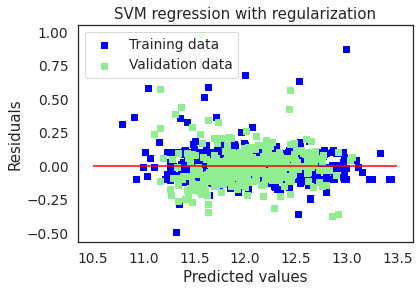

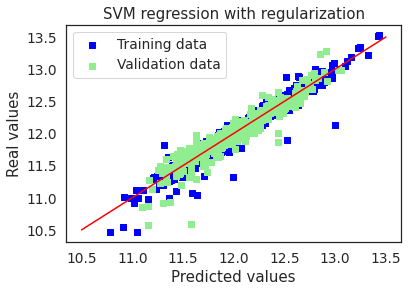

SVR picked up 432 features and eliminated 34 features


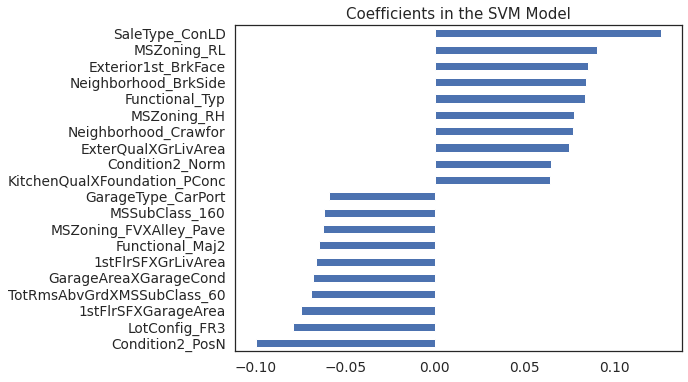

In [31]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [32]:
cv5_train_rmse =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.14957504 0.16388119 0.12907443 0.12985662 0.12969331]
---------------------------------------------------------------------------
cv5 test rmse: [0.13748197 0.14273305 0.14976952 0.13041601 0.11279205]


### 3.6. Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [34]:
rf = RandomForestRegressor(max_features='log2', n_estimators=700)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8859838651485769
MSE: 0.01717156318535979
RMSE: 0.13104031129908
--------------------------------------------------
R-sq: 0.9031731179860589
MSE: 515536987.1234697
RMSE: 22705.439593266405


In [35]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

Text(0.5, 1.0, 'Top 10 Important Features')

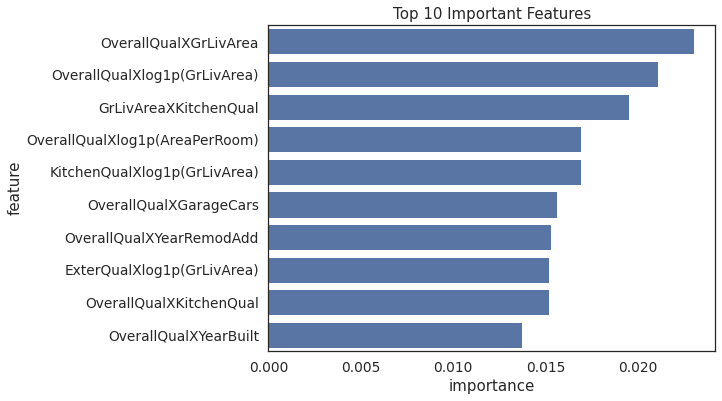

In [36]:
plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [37]:
cv5_train_rmse =  cv_rmse(rf, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(rf, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.16031427 0.14696297 0.14881857 0.15704004 0.11617285]
---------------------------------------------------------------------------
cv5 test rmse: [0.13770206 0.13971686 0.17564878 0.10985181 0.12753898]


### Adaptive Boost

In [49]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)
print(ada_cv.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=None,
                                                       max_depth=25,
                                                       min_samples_leaf=12,
                                                       min_samples_split=15,
                                                       presort=False),
                  learning_rate=0.5, loss='square', n_estimators=400)


In [51]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                             max_depth=25,
                                                             min_samples_leaf=12,
                                                             min_samples_split=15,
                                                             presort=False),
                  learning_rate=0.5, loss='square', n_estimators=400)
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8929462686723992
MSE: 0.01612298043707523
RMSE: 0.12697629872175054
--------------------------------------------------
R-sq: 0.9142483705694496
MSE: 456568834.58448213
RMSE: 21367.471412979172


Text(0.5, 1.0, 'Top 10 Important Features')

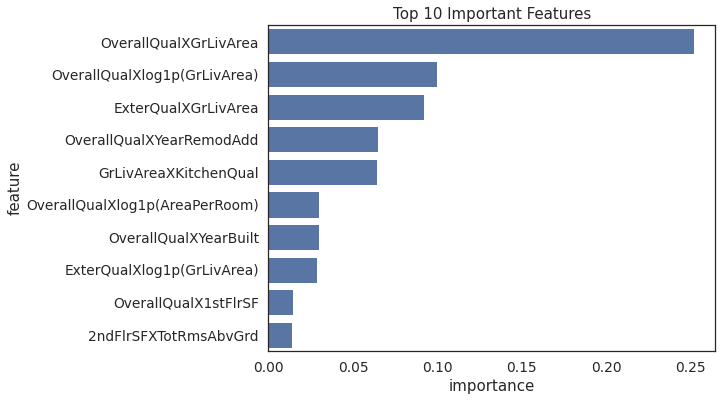

In [52]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [53]:
cv5_train_rmse =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ada, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15207553 0.15063362 0.14058446 0.14781031 0.13087471]
---------------------------------------------------------------------------
cv5 test rmse: [0.13538992 0.14628666 0.17759592 0.09740609 0.12151923]


### Gradient Boost

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

In [55]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9093326699701602
MSE: 0.013655083015084609
RMSE: 0.11685496572711238
--------------------------------------------------
R-sq orig price: 0.9126901529845313
MSE orig price: 464865278.5296248
RMSE orig price: 21560.734647261554


Text(0.5, 1.0, 'Top 10 Important Features')

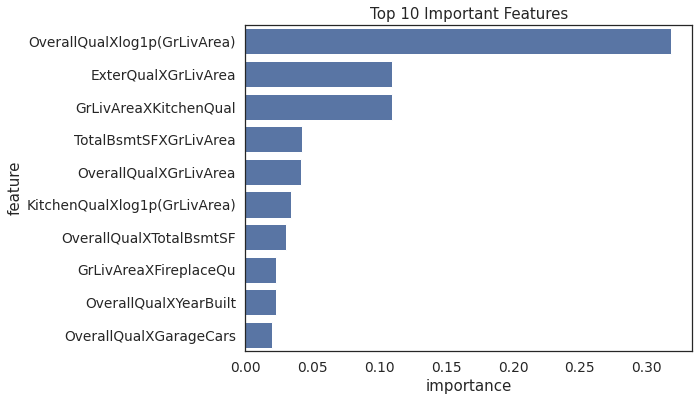

In [56]:
feature_importance = pd.DataFrame(np.round(gbrt.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [57]:
cv5_train_rmse =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15086763 0.14099266 0.13633695 0.14277272 0.11942621]
---------------------------------------------------------------------------
cv5 test rmse: [0.12407977 0.1537511  0.16857555 0.10602924 0.11370106]


## 4. Model Performance

In [58]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_train_rmse,
                           model.cv5_std_train_rmse,
                           model.cv5_mean_test_rmse,
                           model.cv5_std_test_rmse],
                          index=['model',
                                   'train_mean_rmse',
                                   'train_std_rmse',
                                   'test_mean_rmse',
                                   'test_std_rmse']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [59]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [60]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            8 non-null      object 
 1   train_mean_rmse  8 non-null      float64
 2   train_std_rmse   8 non-null      float64
 3   test_mean_rmse   8 non-null      float64
 4   test_std_rmse    8 non-null      float64
dtypes: float64(4), object(1)
memory usage: 448.0+ bytes


Text(0.5, 1.0, 'Train vs. Validation RMSE')

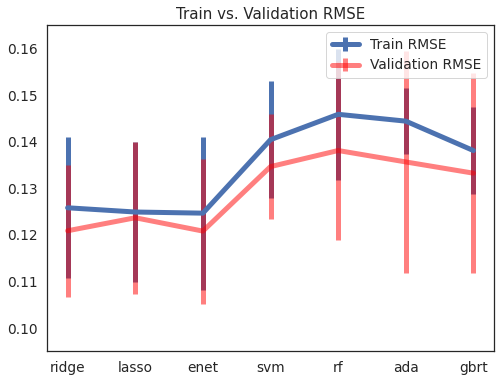

In [61]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_rmse']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_rmse'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_rmse']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_rmse'],
             yerr=test_errorbar_width_array,
             label='Validation RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Validation RMSE')

In [62]:
mod_table.rename(columns={'test_mean_rmse':'val_mean_rmse','test_std_rmse':'val_std_rmse'},inplace=True)

In [63]:
mod_table.sort_values(by=['val_mean_rmse','val_std_rmse'],ascending=[True,True])

,model,train_mean_rmse,train_std_rmse,val_mean_rmse,val_std_rmse
3,enet,0.124649,0.018360,0.120800,0.017403
1,ridge,0.125802,0.016916,0.120868,0.015882
2,lasso,0.124893,0.016813,0.123662,0.018210
7,gbrt,0.138079,0.010441,0.133227,0.023981
4,svm,0.140416,0.014068,0.134639,0.012631
6,ada,0.144396,0.007834,0.135640,0.026589
5,rf,0.145862,0.015654,0.138092,0.021551
0,LR,1.837949,2.985976,0.954793,0.217902


Train and validation RMSE values of the __Lasso Regression__ model are very similar and reasonably low. Lasso regression performed the best on test dataset provided by kaggle. The test RMSE was 0.11840 which placed the submission in the top 5% of kaggle's leaderboard.